# **Data Preprocessing Image Dataset**

This file takes the image dataset for lung cancer and creates several modified versions of the dataset to be used for model training and experiementing 

The choice of modifications is based on the analysis, the needs of different models and for experimental reasons

## Necessary Imports

In [1]:
# Python 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 
import sklearn
assert sklearn.__version__ >= "0.20"

# Pandas
import pandas as pd

import random

# Common imports
import numpy as np
import os
import cv2  

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Loading in original dataset aad scaling to same size

In [2]:
ROOT_PATH = os.path.join("..", "datasets", "3_image", "unprocessed", "Training cases")

# Define subfolders and their corresponding labels
folders_with_labels = {
    "Benign cases": "benign",
    "Malignant cases": "malignant",
    "Normal cases": "normal",
}

# Initialize lists to store image data and labels
image_data = []
labels = []

# Iterate through each folder and load image with labels
for folder, label in folders_with_labels.items():
    folder_path = os.path.join(ROOT_PATH, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust based on image format
            # Load the image in grayscale (adjust if needed)
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Store the image and its label
            image_data.append(image)
            labels.append(label)

# Convert to a DataFrame for easy manipulation
image_og_unbalanced = pd.DataFrame({
    "image": image_data,
    "label": labels
})

# Display the first few rows to verify
print(image_og_unbalanced.shape)
print(image_og_unbalanced.head())

(1097, 2)
                                               image   label
0  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign
1  [[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, ...  benign
2  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign
3  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign
4  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign


#### Scaling images to same pixel width and height

In [3]:
def count_unique_image_sizes(df, image_column='image'):
    """
    Counts unique image sizes in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing images.
        image_column (str): The name of the column with image data.
        
    Returns:
        pd.DataFrame: A DataFrame with unique sizes and their counts.
    """
    # Initialize a list to store image sizes
    image_sizes = []

    # Loop through each image in the specified column
    for image in df[image_column]:
        # Get the shape of the image (height, width)
        height, width = image.shape
        # Append the size as a tuple
        image_sizes.append((height, width))

    # Convert the list to a DataFrame for easy counting and analysis
    size_df = pd.DataFrame(image_sizes, columns=['height', 'width'])

    # Count the unique sizes
    unique_sizes = size_df.value_counts().reset_index(name='count')

    return unique_sizes

# Display dimensions and counts of the images
unique_sizes_df = count_unique_image_sizes(image_og_unbalanced)
print("Unique image sizes and their counts:")
print(unique_sizes_df)


Unique image sizes and their counts:
   height  width  count
0     512    512   1036
1     512    623     31
2     512    801     28
3     331    506      1
4     404    511      1


In [4]:
# Define the target size
target_size = (512, 512)

# Resize each image to the target size
image_og_unbalanced['image'] = image_og_unbalanced['image'].apply(lambda img: cv2.resize(img, target_size, interpolation=cv2.INTER_AREA))

# Display dimensions and counts of the images
unique_sizes_df = count_unique_image_sizes(image_og_unbalanced)
print("Unique image sizes and their counts:")
print(unique_sizes_df)

Unique image sizes and their counts:
   height  width  count
0     512    512   1097


## Modifying dataset and saving as a file

#### Oversample to balance target class

In [5]:
image_og_unbalanced['label'].value_counts()

label
malignant    561
normal       416
benign       120
Name: count, dtype: int64

In [6]:
# Separate each class
normal_class = image_og_unbalanced[image_og_unbalanced['label'] == 'normal']
benign_class = image_og_unbalanced[image_og_unbalanced['label'] == 'benign']
malignant_class = image_og_unbalanced[image_og_unbalanced['label'] == 'malignant']  # Keeping malignant as-is since it's the majority class

# Oversample 'normal' and 'benign' classes to match the 'malignant' count of 561
normal_class_oversampled = normal_class.sample(n=561, replace=True, random_state=42)
benign_class_oversampled = benign_class.sample(n=561, replace=True, random_state=42)

# Combine the oversampled 'normal' and 'benign' instances with the original 'malignant' instances
image_og_balanced = pd.concat([malignant_class, normal_class_oversampled, benign_class_oversampled])

# Shuffle the dataset to mix the classes
image_og_balanced = image_og_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new counts
print(image_og_balanced['label'].value_counts())


label
benign       561
normal       561
malignant    561
Name: count, dtype: int64


The simplest method for oversampling was used - randomly duplicating instances. This is not ideal, however, the target class having equal value distributions could improve performance of certain models.

For all modified datasets both an oversampled (balanced) and unbalanced (original) version will be saved. The versions will be used that are best suited for the concrete machine learning models.

Note: in this case using oversamnpled dataset may lead to differeing results, as the imbalance of the normal class is only 1.3 compared to majority malignant, however, the benign class is heavily imbalanced, a ratio of 4.5. Model may trained on oversampled data may produce overly optimistic results and may not generalise well if oversampled dataset is used.


### 1 - original unmodified image with pixel values between 0 and 255

In [7]:
# Specify the folder path
SAVE_PATH = os.path.join("..", "datasets", "3_image", "processed")

# Specify file names (to be saved)
og_unbalanced_file_path = os.path.join(SAVE_PATH, "3_og_ub.csv")
og_balanced_file_path = os.path.join(SAVE_PATH, "3_og_b.csv")

# Check if the file already exists
if not os.path.exists(og_unbalanced_file_path):
    # Save the DataFrame if it doesn't exist
    image_og_unbalanced.to_csv(og_unbalanced_file_path, index=False)
    print(f"File saved at {og_unbalanced_file_path}")
else:
    print(f"File already exists at {og_unbalanced_file_path}")

# Repeat for balanced dataset 
if not os.path.exists(og_balanced_file_path):
    image_og_balanced.to_csv(og_balanced_file_path, index=False)
    print(f"File saved at {og_balanced_file_path}")
else:
    print(f"File already exists at {og_balanced_file_path}")

File already exists at ../datasets/3_image/processed/3_og_ub.csv
File already exists at ../datasets/3_image/processed/3_og_b.csv


### 2 - preprocessed and normalized

As followed from the image dataset analysis, the lung crossection covers different areas in different images and there are different background elements like noise in the background. It could have a positive impact on model performance if the important data from images is as consistent across the canvas area as possible with minimall noise variation. On top of that, it is common practice to normalize pixel values from range [0,255] to a range [0,1]

#### Focusing on the lung crossection

The following function removes background elements along with the ribcage and resizes the resulting lung crossesction to fit the size of the frame

In [189]:
def isolate_and_resize_lung_area(image, output_size=(512, 512)):
    # Step 1: Convert to grayscale (if not already)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    # Step 2: Apply a threshold to create a binary image
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Step 3: Use morphological operations to remove small noise
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Step 4: Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 5: Filter contours by area and choose the one likely to be the lung
    min_area = 10000  # Minimum area threshold (adjust as needed)
    max_area = 500000  # Maximum area threshold (adjust as needed)
    lung_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]
    largest_contour = max(lung_contours, key=cv2.contourArea) if lung_contours else None

    # Step 6: Create a mask with the largest contour filled in, if found
    lung_mask = np.zeros_like(binary)
    if largest_contour is not None:
        cv2.drawContours(lung_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Step 7: Apply erosion to remove nearby edges like the rib cage
    erosion_kernel = np.ones((3, 3), np.uint8)
    lung_mask = cv2.erode(lung_mask, erosion_kernel, iterations=1)

    # Step 8: Apply the mask to the original grayscale image to keep only the lung area
    isolated_lung = cv2.bitwise_and(gray, gray, mask=lung_mask)

    # Step 9: Find the bounding box of the lung area
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Step 10: Crop the lung area based on the bounding box
    cropped_lung = isolated_lung[y:y+h, x:x+w]

    # Step 11: Resize the cropped lung area to the desired output size
    resized_lung = cv2.resize(cropped_lung, output_size, interpolation=cv2.INTER_AREA)

    return resized_lung

Next, this fucntion is applied to every instance of the image column in the original dataframes

In [190]:
# Function to apply to each image
def process_images_in_dataframe(df):
    processed_images = []
    labels = []
    
    for idx, row in df.iterrows():
        # Extract the image and label
        image = row['image']
        label = row['label']
        
        # Process the image
        processed_image = isolate_and_resize_lung_area(image)
        
        # Append the processed image and label to lists
        processed_images.append(processed_image)
        labels.append(label)
    
    # Create a new DataFrame with processed images and labels
    focused_df = pd.DataFrame({'image': processed_images, 'label': labels})
    
    return focused_df

# Apply the function to the original unbalanced dataset
image_focused_unbalanced = process_images_in_dataframe(image_og_unbalanced)
image_focused_balanced = process_images_in_dataframe(image_og_balanced)

# Check value counts
#image_focused_unbalanced['label'].value_counts()
#image_focused_balanced["label"].value_counts()



The following portion of code demonstrates the result of the transformation by dislaying the original and focused images side by side

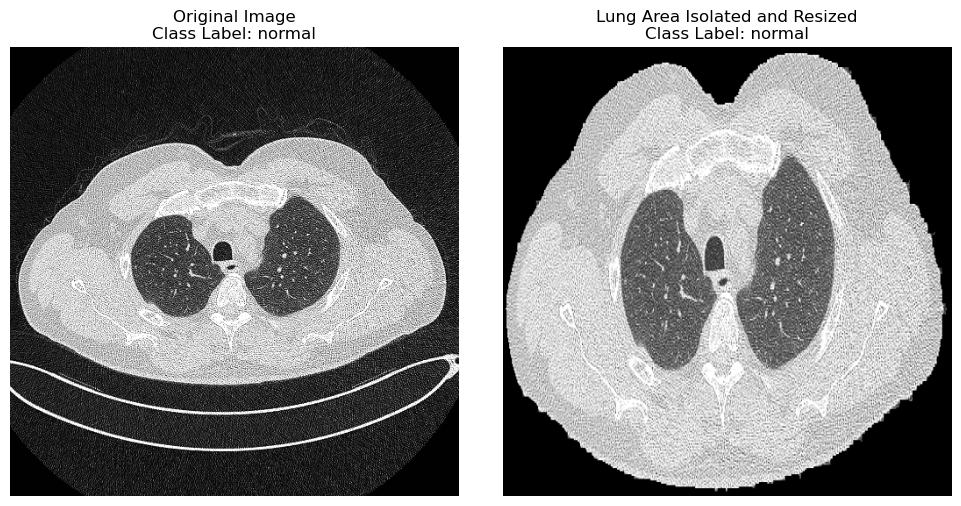

In [220]:
# Total number of images in the dataset
num_images = 1096

# Randomly select an index
random_index = random.randint(0, num_images - 1)

# Get the original and processed images along with the label
original_image = image_og_unbalanced.loc[random_index, 'image']
processed_image = image_focused_unbalanced.loc[random_index, 'image']
label = image_og_unbalanced.loc[random_index, 'label']

# Display the images side by side with titles
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title(f"Original Image\nClass Label: {label}")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

# Lung area isolated and resized image
plt.subplot(1, 2, 2)
plt.title(f"Lung Area Isolated and Resized\nClass Label: {label}")
plt.imshow(processed_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

#### Normalizing pixel values from [0,255] to a range [0,1]

In [403]:
# Function to normalize images in a DataFrame
def normalize_images(df):
    normalized_images = []
    
    for image in df['image']:
        # Normalize pixel values to [0, 1]
        normalized_image = image / 255.0
        normalized_images.append(normalized_image)
    
    # Create a new DataFrame with normalized images and retain labels
    normalized_df = df.copy()
    normalized_df['image'] = normalized_images
    
    return normalized_df

# Normalize images in both dataframes
image_normalized_balanced = normalize_images(image_focused_balanced)
image_normalized_unbalanced = normalize_images(image_focused_unbalanced)

# Verify normalization
image_normalized_balanced.head()
#image_normalized_unbalanced.head()
#image_normalized_balanced['label'].value_counts()
#image_normalized_unbalanced['label'].value_counts()

,image,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",benign
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",normal
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",benign
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",malignant
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",malignant


Next, the normalizde versions are saved to file

In [703]:
# Specify file names (to be saved)
nrml_unbalanced_file_path = os.path.join(SAVE_PATH, "3_nrml_ub.csv")
nrml_balanced_file_path = os.path.join(SAVE_PATH, "3_nrml_b.csv")

# Check if the file already exists
if not os.path.exists(nrml_unbalanced_file_path):
    # Save the DataFrame if it doesn't exist
    image_normalized_unbalanced.to_csv(nrml_unbalanced_file_path, index=False)
    print(f"File saved at {nrml_unbalanced_file_path}")
else:
    print(f"File already exists at {nrml_unbalanced_file_path}")

# Repeat for balanced dataset 
if not os.path.exists(nrml_balanced_file_path):
    image_normalized_balanced.to_csv(nrml_balanced_file_path, index=False)
    print(f"File saved at {nrml_balanced_file_path}")
else:
    print(f"File already exists at {nrml_balanced_file_path}")

File already exists at ../datasets/3_image/processed/3_nrml_ub.csv
File already exists at ../datasets/3_image/processed/3_nrml_b.csv


#### 3 - Edge detection on the focused dataframe

Edge detection was explored in data analysis and is applied to the focused images in this section.

It highlights the edges and is a form of feature extraction. It will be interesting to see how using this variation will affect model performance.

In [626]:
# Function to apply Canny edge detection to images in a DataFrame and replace the original images
def apply_edge_detection_inplace(df):
    for i in range(len(df)):
        # Apply Canny edge detection on the image and replace the original image
        edges = cv2.Canny((df.at[i, 'image'] * 255).astype('uint8'), 100, 200)  # Ensure image is in [0, 255] range for edge detection
        df.at[i, 'image'] = edges  # Replace the original image with the edge-detected version

    return df

# Apply edge detection in-place to both balanced and unbalanced focused datasets
image_edges_balanced = apply_edge_detection_inplace(image_focused_balanced)
image_edges_unbalanced = apply_edge_detection_inplace(image_focused_unbalanced)


# Function to display edge detection samples for each class
def display_edge_detection_samples(df):
    class_edge_images = {}
    for label in df['label'].unique():
        # Select a random edge-detected image for each class
        sample_edge_image = df[df['label'] == label].sample(1)['image'].values[0]
        class_edge_images[label] = sample_edge_image

    # Display edge-detected images
    plt.figure(figsize=(15, 5))
    for i, (label, edge_image) in enumerate(class_edge_images.items()):
        plt.subplot(1, len(class_edge_images), i + 1)
        plt.imshow(edge_image, cmap='gray')
        plt.title(f"Edges: {label}")
        plt.axis('off')
    plt.show()

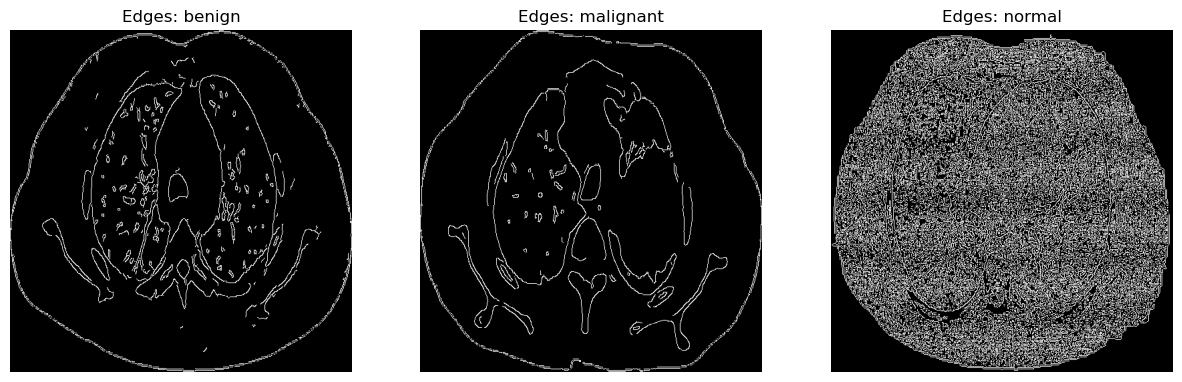

In [698]:
# Display edge detection samples from the balanced dataset
display_edge_detection_samples(image_edges_unbalanced)

For most images the edge detection results in well defined and clear edges, but for some cases in normal ad beningn classes, the resulting image devolves into a pattern of noise. This imperfection will be left in the dataset, as conditions in real life arent perfect and no dataset is perfect either.

Although, in oher scnarious, outlier results can be filtered out based on pixel intensity or the detctionlgorithm can be tweaked to attempt a more consistent detection.

Normalize pixel values or edge detected dataframes:

In [ ]:
image_edges_balanced = normalize_images(image_edges_balanced)
image_edges_unbalanced = normalize_images(image_edges_unbalanced)

# Verify normalization
#image_edges_balanced.head()
#image_edges_unbalanced.head()
#image_edges_balanced['label'].value_counts()
#image_edges_unbalanced['label'].value_counts()

label
malignant    561
normal       416
benign       120
Name: count, dtype: int64

Next, save the variation with edge detection to file

In [ ]:
# Specify file names (to be saved)
ed_unbalanced_file_path = os.path.join(SAVE_PATH, "3_ed_ub.csv")
ed_balanced_file_path = os.path.join(SAVE_PATH, "3_ed_b.csv")

# Check if the file already exists
if not os.path.exists(ed_unbalanced_file_path):
    # Save the DataFrame if it doesn't exist
    image_edges_unbalanced.to_csv(ed_unbalanced_file_path, index=False)
    print(f"File saved at {ed_unbalanced_file_path}")
else:
    print(f"File already exists at {ed_unbalanced_file_path}")

# Repeat for balanced dataset 
if not os.path.exists(ed_balanced_file_path):
    image_edges_balanced.to_csv(ed_balanced_file_path, index=False)
    print(f"File saved at {ed_balanced_file_path}")
else:
    print(f"File already exists at {ed_balanced_file_path}")